In [93]:
import torch
import torch.nn as nn
import albumentations as A
import numpy as np
import cv2
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict, Optional
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision import models
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import logging
from torch.utils.data import random_split
from dataclasses import dataclass

In [94]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonytherrien/dog-vs-cat")

print("Path to dataset files:", path)

Path to dataset files: /Users/daniel/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3


In [95]:
path = Path(path)

for item in Path(path).iterdir():
    print(item)



/Users/daniel/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals


In [96]:
animal_dir = path / "animals"
animal_dir

PosixPath('/Users/daniel/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals')

In [97]:
animal_data = ImageFolder(animal_dir)
animal_data, animal_data.classes, animal_data.class_to_idx, animal_data.targets

(Dataset ImageFolder
     Number of datapoints: 1000
     Root location: /Users/daniel/.cache/kagglehub/datasets/anthonytherrien/dog-vs-cat/versions/3/animals,
 ['cat', 'dog'],
 {'cat': 0, 'dog': 1},
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [98]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_indices, val_indices = train_test_split(
    range(len(animal_data)), test_size=0.2, random_state=42, stratify=animal_data.targets
)
train_data_subset = Subset(animal_data, train_indices)
test_data_subset = Subset(animal_data, val_indices)
len(train_data_subset), len(test_data_subset), train_data_subset, test_data_subset

(800,
 200,
 <torch.utils.data.dataset.Subset at 0x351356900>)

In [99]:
@dataclass
class Config:
    batch_size: int = 32
    num_workers: int = 2
    pin_memory: bool = True
    aug_prob: float = 0.5
    transforms: Optional[A.Compose] = None
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    image_size: Tuple[int,int] = (224,224)
    learning_rate = 1e-3
    num_classes: int = 2
    num_epochs: int = 10

config = Config()

In [115]:
def get_transforms(config: Config) -> A.Compose:
    train_transforms = A.Compose([
        A.Resize(config.image_size[0], config.image_size[1]),
        A.HorizontalFlip(p=config.aug_prob),
        
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=config.aug_prob),
        
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.HueSaturationValue(hue_shift_limit=20,sat_shift_limit=30,val_shift_limit=20)
        ],p=config.aug_prob),
        A.OneOf([
            A.GaussianBlur(),
            A.MotionBlur(),
            A.GaussNoise(var_limit=(10.0, 50.0))
        ],p=config.aug_prob),
        A.CoarseDropout(
            max_holes = 8,
            max_height= 12,
            max_width= 12,
            p=config.aug_prob
        ),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    val_transforms = A.Compose([
       A.Resize(config.image_size[0], config.image_size[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    show_transforms = A.Compose([
        A.Resize(config.image_size[0], config.image_size[1]),
        A.HorizontalFlip(p=config.aug_prob),
        
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=config.aug_prob),
        
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
            A.HueSaturationValue(hue_shift_limit=20,sat_shift_limit=30,val_shift_limit=20)
        ],p=config.aug_prob),
        A.OneOf([
            A.GaussianBlur(),
            A.MotionBlur(),
            A.GaussNoise(var_limit=(10.0, 50.0))
        ],p=config.aug_prob),
        A.CoarseDropout(
            max_holes = 4,
            max_height= 8,
            max_width= 8,
            p=config.aug_prob
        ),
    
        ToTensorV2()
    ])
    
    return{"train_transforms": train_transforms, "val_transforms": val_transforms, "show_transforms": show_transforms}

    

In [142]:
import random
class AnimalDataset(Dataset):
    def __init__(self, data:ImageFolder, transforms: A.Compose, config: Config):
        self.data = data
        self.transforms = transforms
        self.config = config
        
        self.images = self.data.samples
        self.classes = self.data.classes
        self.class_to_idx = self.data.class_to_idx
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx:int) -> Tuple[torch.Tensor,int]:
        img_path, label = self.images[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        return img, label
    
    def visualize_images(self, num_images:int=5,images_per_row:int = 3,title=None,seed = None) -> None:
        n_rows = int(np.ceil(num_images/images_per_row))
        if seed is not None:
            random.seed(seed)
        fig,ax = plt.subplots(n_rows,images_per_row, figsize=(20,5 * n_rows))
        ax= ax.flatten()
        if title is not None:
            fig.suptitle(title)
        
        for i in range(num_images):
            rand = random.randint(0,len(self)-1)
            img, label = self[rand]
            if type(img) is torch.Tensor:
                img = img.permute(1,2,0)
          
            ax[i].imshow(img)
            ax[i].set_title(f"Label: {self.classes[label]}")
        
           
        
       

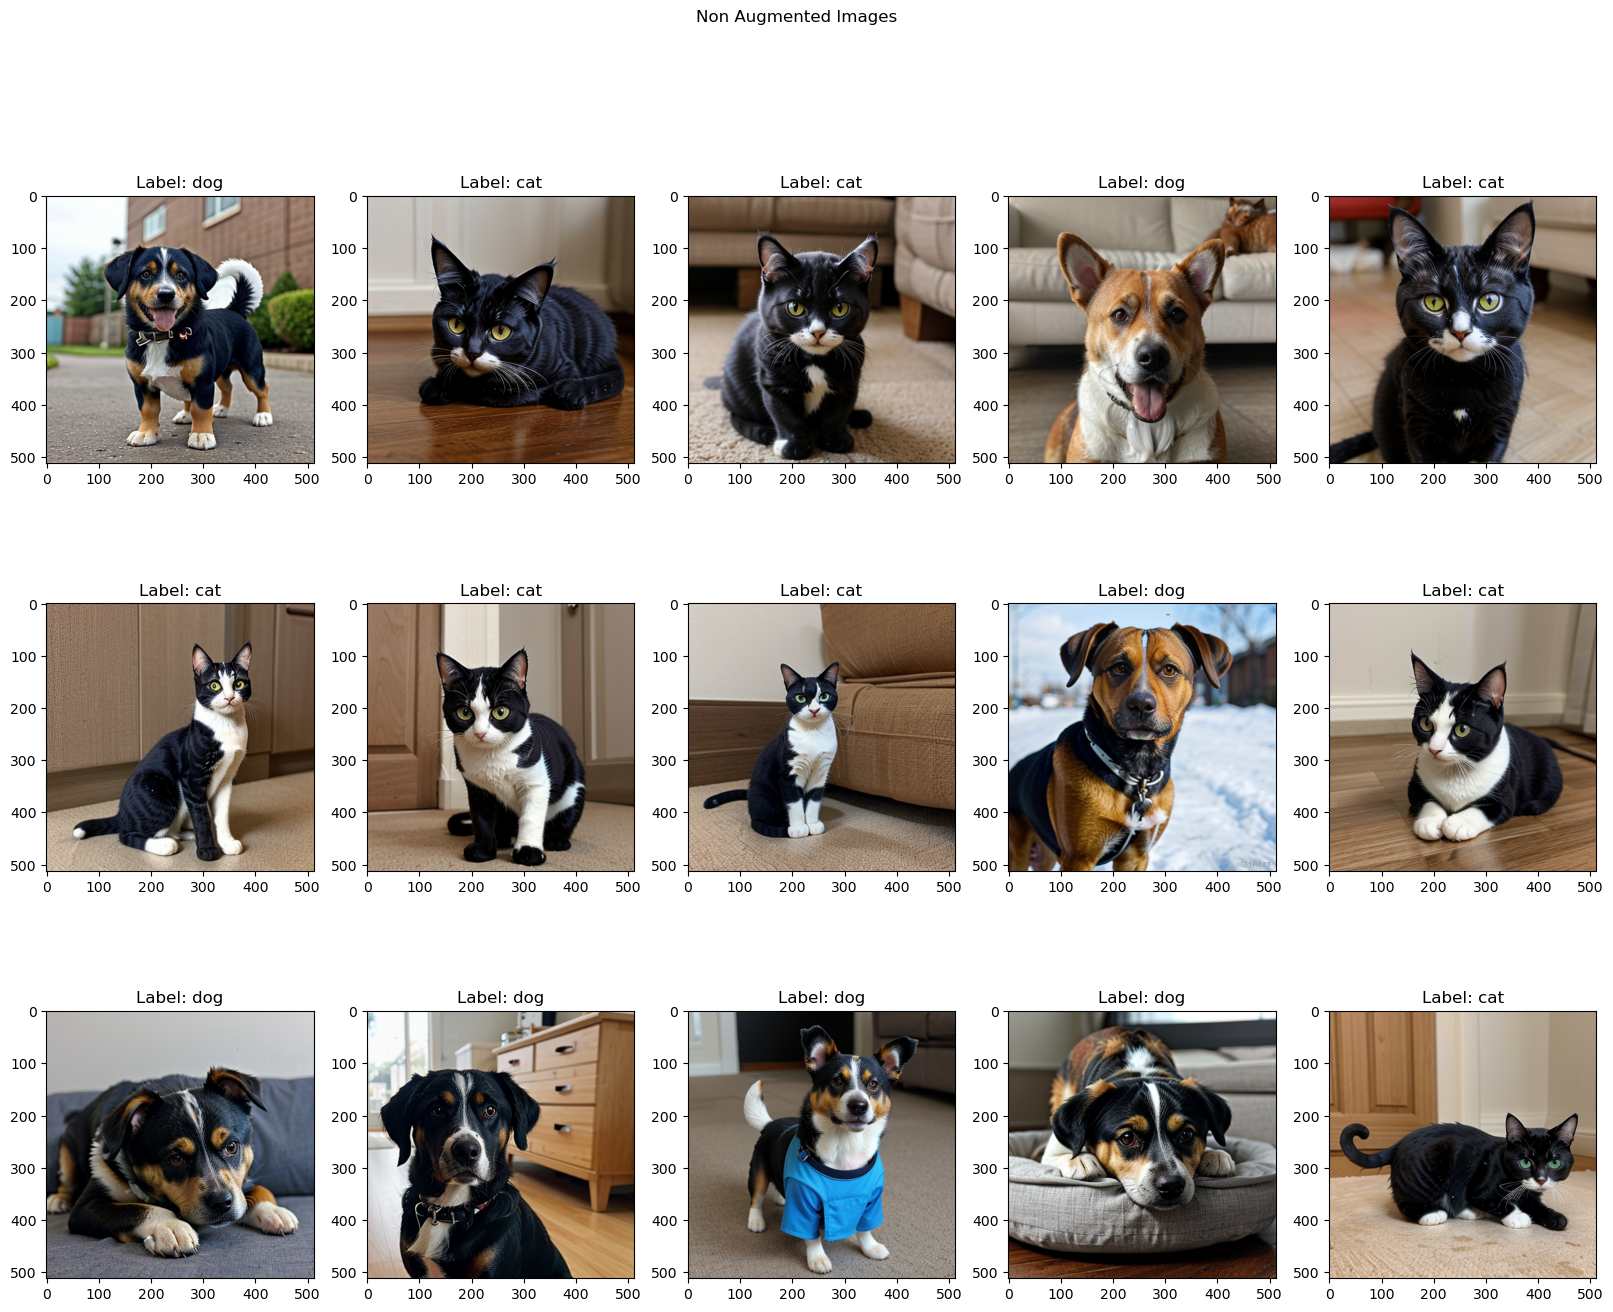

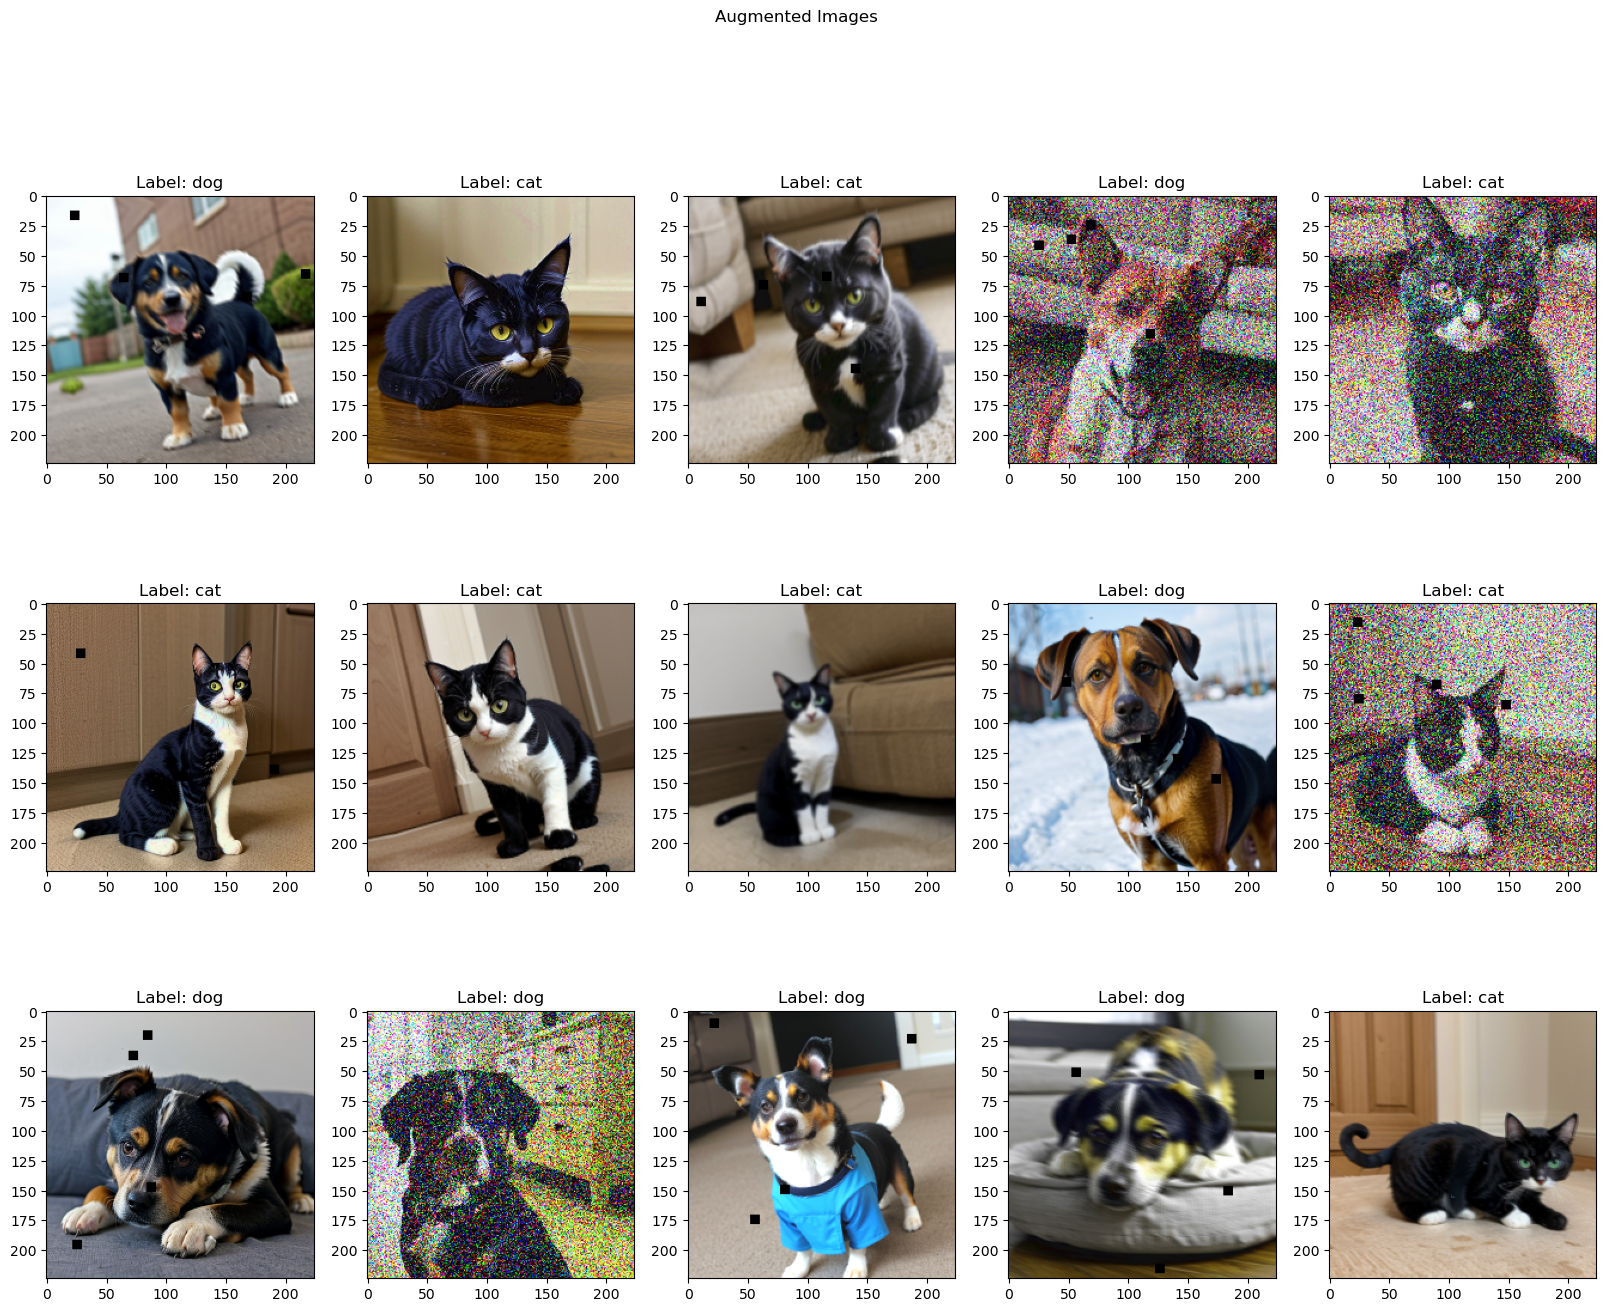

In [143]:
train_data = train_data_subset.dataset
test_data = test_data_subset.dataset


non_augmented_train_dataset = AnimalDataset(data=train_data,transforms=None,config=config)
non_augmented_train_dataset.visualize_images( num_images=15, images_per_row=5,title="Non Augmented Images",seed=42)
augmented_train_dataset = AnimalDataset(data=train_data,transforms=get_transforms(config=config)['show_transforms'],config=config)
augmented_train_dataset.visualize_images( num_images=15, images_per_row=5,title="Augmented Images",seed=42)
